In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('purchase_data.csv')

In [3]:
# Creates the features to be analyzed by K-Means
customer_spending = data.groupby('Customer ID').agg({
    'Purchase Amount': ['sum', 'count'],
    'Product ID': pd.Series.nunique
}).reset_index()
customer_spending.columns = ['Customer ID', 'TotalSpending', 'PurchaseFrequency', 'UniqueProducts']

scaler = StandardScaler()
customer_scaled = scaler.fit_transform(customer_spending[['TotalSpending', 'PurchaseFrequency', 'UniqueProducts']])

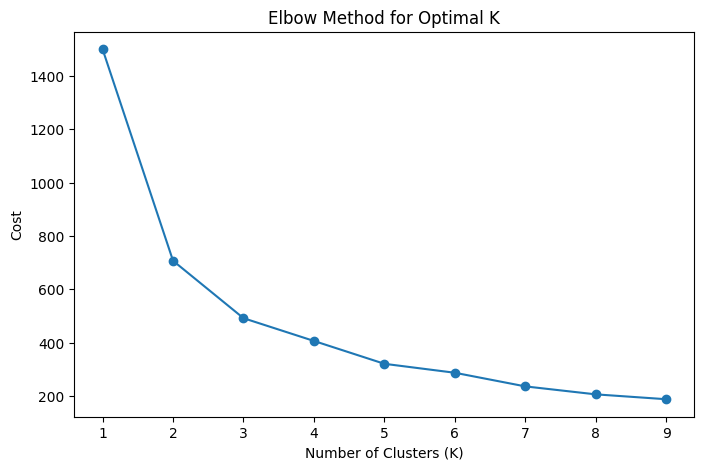

In [4]:
# Determine Optimal Number of Clusters (Elbow Method)
costs = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(customer_scaled)
    costs.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, costs, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal K')
plt.show()

In [5]:
# We will be segmenting into 3 clusters

kmeans = KMeans(n_clusters=3, random_state=42)
customer_spending['Cluster'] = kmeans.fit_predict(customer_scaled)


customer_spending

,Customer ID,TotalSpending,PurchaseFrequency,UniqueProducts,Cluster
0,C001,846.08,11,10,2
1,C002,710.56,11,10,2
2,C003,934.36,9,9,2
3,C004,929.69,11,11,2
4,C005,792.25,10,10,2
...,...,...,...,...,...
495,C496,1480.85,13,12,1
496,C497,1749.34,14,11,1
497,C498,754.54,9,9,2
498,C499,1125.71,12,12,2


In [6]:
# Reassign cluster labels based on logical trends
cluster_means = customer_spending.groupby('Cluster')[['TotalSpending', 'PurchaseFrequency']].mean()
sorted_clusters = cluster_means.sort_values(by=['TotalSpending', 'PurchaseFrequency'], ascending=[False, True]).index.tolist()
cluster_labels = {sorted_clusters[0]: "High Spenders", sorted_clusters[1]: "Frequent Shoppers", sorted_clusters[2]: "Occasional Buyers"}
customer_spending['ClusterLabel'] = customer_spending['Cluster'].map(cluster_labels)


In [7]:
data = data.merge(customer_spending[['Customer ID', 'Cluster', 'ClusterLabel']], on='Customer ID', how='left')

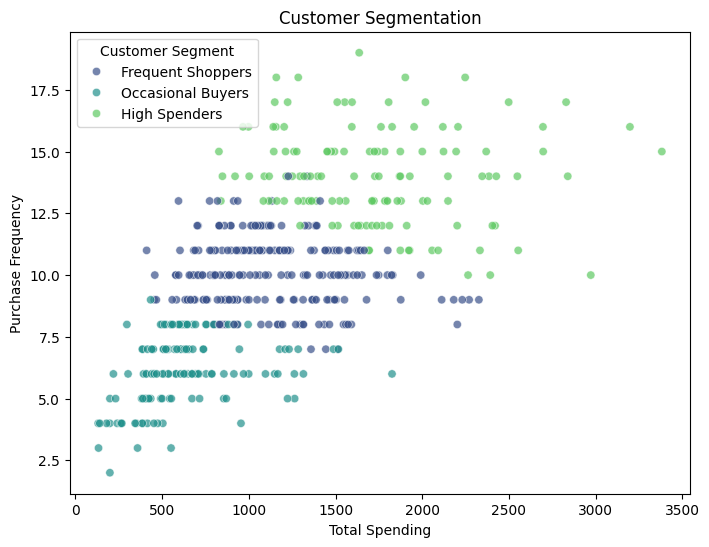

In [8]:
# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=customer_spending['TotalSpending'],
    y=customer_spending['PurchaseFrequency'],
    hue=customer_spending['ClusterLabel'],
    palette='viridis', alpha=0.7
)

plt.xlabel('Total Spending')
plt.ylabel('Purchase Frequency')
plt.title('Customer Segmentation')
plt.legend(title='Customer Segment')
plt.show()

In [9]:
output_file = 'customer_segmentation.csv'
data.to_csv(output_file, index=False)

## These are some clusters stats:

In [10]:
cluster_summary = customer_spending.groupby('Cluster').agg({
    'TotalSpending': ['mean', 'min', 'max'],
    'PurchaseFrequency': ['mean', 'min', 'max']
    }).reset_index()

cluster_summary.columns = ['Cluster', 'Avg_Spent', 'Min_Spent', 'Max_Spent',
                           'Avg_Purchases', 'Min_Purchases', 'Max_Purchases']
print(cluster_labels)
print(cluster_summary)

{1: 'High Spenders', 2: 'Frequent Shoppers', 0: 'Occasional Buyers'}
   Cluster    Avg_Spent  Min_Spent  Max_Spent  Avg_Purchases  Min_Purchases  \
0        0   626.251176     131.67    1825.61       6.169118              2   
1        1  1731.168065     827.70    3381.26      14.008065             10   
2        2  1119.834458     410.90    2326.38      10.100000              7   

   Max_Purchases  
0              9  
1             19  
2             14  
